
**Created by:**

Bálint Kovács, Viktor Varga

<br>

<img src="https://docs.google.com/uc?export=download&id=1WzgXsCoz8O-NeBlJTbuLPC1iIFDmgYt1" style="display:inline-block">
<hr>

# Képek multi-class klasszifikációja konvolúciós neuronhálóval

**Feladat:** Tanuljuk meg megkülönböztetni 10 különböző kategóriát ábrázoló képeket!

A képeket a Pascal VOC Challenge (2012) adatbázisából nyerjük. Az adatbázis eredetileg különböző felbontású képfájlokat tartalmaz. A képek tipikus felbontása 400x500 (y,x) pixel körüli. Az előfeldolgozás során a képeket betöltöttünk, kivágtuk (crop) a legnagyobb lehetséges képre helyezhető, középre igazított négyzet alakú régiókat, majd egységesen 128x128 pixeles felbontásra skáláztuk a képet. Az így, egységes méretre hozott képeket a címkékkel együtt egy pickle archívumba szerializáltuk. Az előfeldolgozáshoz szükséges kód a notebookba nem került be. Itt, az említett, előzőleg kimentett pickle archívumot töltjük be és már csak az abban, numpy tömbök formájában tárolt képekkel és címkékkel kezdünk el dolgozni.

**(A notebookban nem tárgyalt) képek, videók manipulációjára** az OpenCV (import cv2) és esetleg a PIL (import PIL) csomagok ajánlottak.

- OpenCV-vel képek betöltése: `cv2.imread(...)`
- OpenCV-vel képek átméretezése: `cv2.resize(...)`

Python dokumentáció OpenCV-hez: https://opencv-python-tutroals.readthedocs.io/en/latest/index.html 

OpenCV esetén a képeket reprezentáló Numpy tömbök alakja általában `(size_y, size_x, n_channels)` színes képek esetén és `(size_y, size_x)` szürkeárnyalatos képek esetén. Típusuk alapesetben `np.uint8`, ami 0 és 255 közti értéket tárol, képek esetén egy pixel egy csatornájának a fényerejét. Színes képek esetén a default channel sorrend OpenCV-vel: BGR. Az ebben a notebookban letöltött pickle archívumban már RGB a channel sorrend, így matplotlib-bel történő kirajzoláskor nem kapunk furcsa színeket.

**GPU használata Google Colab-ban:** A konvolúciós háló betanítása több erőforrást igényel, így érdemes legalább a betanításhoz bekapcsolni a GPU gyorsítást. *Edit -> Notebook settings -> Hardware accelerator: GPU*

Az adatbázis (Pascal VOC Challenge, 2012) forrása: http://host.robots.ox.ac.uk/pascal/VOC/

## Importok

In [ ]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers

## Adatbázis betöltése

**Letöltjük az előfeldolgozott adatbázist**, ha nem található meg a futtatókörnyezet tárhelyén. A képeket tartalmazó fájl mérete 300 megabájt körüli, 1-2 percet igénybe vehet a letöltése a futatókörnyezet tárhelyére. A tárhelyen, előfordul, hogy elérhetők maradnak a fájlok akkor is, ha a futtatókörnyezetről lekapcsolódunk, de ez nem garantált.

In [ ]:
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/class_data.pkl
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/class_label.pkl
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/seg_data.pkl
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/seg_label.pkl

File ‘VOC2012/class_data.pkl’ already there; not retrieving.

File ‘VOC2012/class_label.pkl’ already there; not retrieving.

File ‘VOC2012/seg_data.pkl’ already there; not retrieving.

File ‘VOC2012/seg_label.pkl’ already there; not retrieving.



**Töltsük be az adatbázist** a letöltött pickle archívumokból! A pickle csomag a legtöbb Python objektumot képes szerializálni és fájllá alakítani a `pickle.dump(...)` művelet segítségével. A `pickle.load(...)` betölti és helyreállítja az elcsomagolt objektumot az archívumból. A műveletek használatához egy megnyitott fájl objektum szükséges, amit az `open(...)` beépített függvény biztosít. Bináris formában tárolt fájl olvasásához `'rb'`, írásához (dump) `'wb'` módban kell megnyitni a fájlt. További megnyitási módok (pl. szöveges mód) kódjai itt találhatók: https://docs.python.org/3/library/functions.html#open 

In [ ]:
CAT_NAMES = ['aeroplane', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'sheep']

with open('VOC2012/class_data.pkl', 'rb') as f:
    arr_cl_data = pickle.load(f)
with open('VOC2012/class_label.pkl', 'rb') as f:
    arr_cl_labs = pickle.load(f)
with open('VOC2012/seg_data.pkl', 'rb') as f:
    arr_seg_data = pickle.load(f)
with open('VOC2012/seg_label.pkl', 'rb') as f:
    arr_seg_labs = pickle.load(f)
    
print("Shape of classification image array:", arr_cl_data.shape)
print("Shape of classification label array:", arr_cl_labs.shape)
print("Shape of segmentation image array:", arr_seg_data.shape)
print("Shape of segmentation label array:", arr_seg_labs.shape)

Shape of classification image array: (6638, 128, 128, 3)
Shape of classification label array: (6638, 10)
Shape of segmentation image array: (1735, 128, 128, 3)
Shape of segmentation label array: (1735, 128, 128)


Az `arr_cl_data` tömb tárolja a képeket (n_image, size_y, size_x, n_channels) alakban. A képeken található objektumok tíz kategóriába sorolhatók, a `CAT_NAMES` listában adjuk meg az egyes kategóriák neveit. Egy képen előfordulhat objektum több kategóriából is, ezért a `arr_cl_labs` (n_image, n_categories=10) alakú tömb minden elemnél, minden egyes kategóriánál `1` értéket tárol, ha az adott kategóriájú objektum jelen van a képen és `0` értéket, ha nincs.

Példaként **rajzoljunk ki néhány véletlenszerűen képet** a képek tömbjéből és írjuk ki a hozzájuk tartozó sorokat a címketömbből!


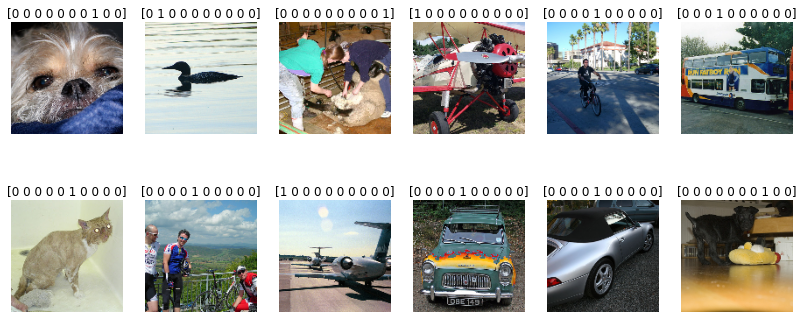

In [ ]:
sample_idxs = np.random.choice(arr_cl_data.shape[0], size=12)

fig, axs = plt.subplots(2,6)
fig.set_figwidth(14)
fig.set_figheight(6)

for plot_idx in range(12):
    axs[plot_idx//6, plot_idx%6].imshow(arr_cl_data[sample_idxs[plot_idx]])
    text = arr_cl_labs[sample_idxs[plot_idx]]
    axs[plot_idx//6, plot_idx%6].axis("off")
    axs[plot_idx//6, plot_idx%6].set_title(str(text))

## Adatbázis szűrése

Válasszuk ki azokat a képeket, melyeken csak egy objektum szerepel!

In [ ]:
one_object_mask = np.sum(arr_cl_labs, axis=1) == 1
xs = arr_cl_data[one_object_mask]
ys = arr_cl_labs[one_object_mask]
xs.shape[0]

6333

## Adatok felosztása

Válasszuk szét a tömböket tanító, validációs és teszthalmazra (60/20/20%)!

In [ ]:
val_offset = int(xs.shape[0]*0.6)
test_offset = int(xs.shape[0]*0.8)

x_train_unnnormed = xs[:val_offset]
x_val_unnnormed = xs[val_offset:test_offset]
x_test_unnnormed = xs[test_offset:]

y_train_unnormed = ys[:val_offset]
y_val_unnormed = ys[val_offset:test_offset]
y_test_unnormed = ys[test_offset:]

## Adatok normalizálása

Mivel most ismert, azonos nagyságrendű input változóink vannak (kép pixelek színcsatornáinak fényereje), ezért nem szükséges (és ebben a konkrét esetben nem is ajánlott) újraskálázni őket változónként függetlenül.

Azonban, mélyhálók tanulásához ideális, ha akár az input, akár egy-egy köztes rétegben az értékek 0 közepűek (és _megközelítőleg_ 1 szórásúak). Most ezt úgy fogjuk elérni, hogy **a képek pixeleinek [0,255] közti értékeit a [-1,1] intervallumra skálázzuk** lineárisan (az összes változót ugyanazzal a számmal). A skálázás előtt **az eddigi `uint8` egész adattípusú képeket valós számokat reprezentáló `float32` típusra konvertáljuk**, hogy ne legyünk bajban a kisebb értékekkel a skálázás után. Az input mellett a címkéket is konvertáljuk `float32` típusúvá, hiszen a neuronháló betanításhoz ez szükséges, mind az inputon, mind az outputon.

In [ ]:
x_train = x_train_unnnormed.astype(np.float32)/127.5 - 1.
x_val = x_val_unnnormed.astype(np.float32)/127.5 - 1.
x_test = x_test_unnnormed.astype(np.float32)/127.5 - 1.
                                 
y_train = y_train_unnnormed.astype(np.float32)
y_val = y_val_unnnormed.astype(np.float32)  
y_test = y_test_unnnormed.astype(np.float32)                                

## Konvolúciós háló deifiniálása

Definiáljuk a konvolúciós neuronhálót, melyet klasszifikációra fogunk használni. A háló elején, a szokásos módon, felváltva alkalmazzunk konvolúciós és pooling rétegeket, egészen addig, amíg az input kép 128x128-as felbontásáról 8x8-as felbontású heatmap-ekre jutunk. Innen, kilapítás után, további három teljesen összekötött réteget alkalmazzunk. Az utolsó réteg a multi-class klasszifikációhoz szükséges jellemzőkkel rendelkezzen: minden kategóriának legyen egy output neuronja, amiben a model az adott kategória valószínűségét becsli az adott inputra.  A rétegek közt néhol dropout-ot helyezzünk el.

A konvolúciós rétegeket 'same' padding módban használjuk. Ez a konvolúció alkalmazása előtt a kép széléhez pontosan annyira széles sávokat fűz, mellyel a konvolúciót elvégezve a kimeneti heatmap mérete az eredeti kép méretével egyezik. Padding kikapcsolásához a 'valid' módot kell használni, ekkor csökkeni fog a kimeneti hőtérkép mérete.

In [ ]:
cl_model = Sequential()
cl_model.add(Conv2D(20, (3,3), input_shape=(128,128, 3), activation="relu", padding="same"))
cl_model.add(MaxPooling2D((2,2))) # output: 64x64X20
cl_model.add(Conv2D(40, (3,3), activation="relu", padding="same"))
cl_model.add(MaxPooling2D((2,2))) # output: 32x32x40
cl_model.add(Dropout(0.3))
cl_model.add(Conv2D(40, (3,3), activation="relu", padding="same"))
cl_model.add(MaxPooling2D((2,2))) #output: 16x16x40
cl_model.add(Dropout(0.3))
cl_model.add(Conv2D(40, (3,3), activation="relu", padding="same"))
cl_model.add(MaxPooling2D((2,2))) #output: 8x8x40
cl_model.add(Dropout(0.3))
cl_model.add(Flatten())
cl_model.add(Dense(400, activation="relu"))
cl_model.add(Dropout(0.3))
cl_model.add(Dense(100, activation="relu"))
cl_model.add(Dense(10, activation="softmax"))

cl_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
cl_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 20)      560       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 40)        7240      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 40)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 40)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 40)        14440     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 40)       

## Adataugmentáció

Az adatbázisunk 6333 képével sajnos nem túl nagy: már a fent definiált háló is könnyedén túltanulna rajta. **Ahhoz, hogy a túltanulás hatását enyhítsük, szükség lesz a képek augmentációjára**. A tipikus képi augmentációkat (eltolás, zaj, dropout, color shift) Numpy és (forgatás, skálázás) OpenCV segítségével, kézzel megírhatjuk.

OpenCV geometriai transzformációk: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


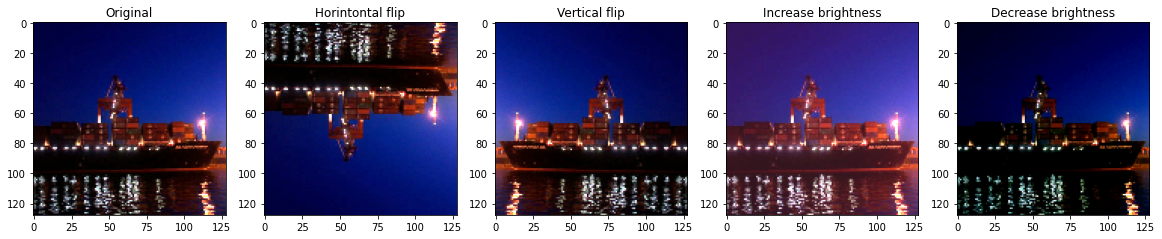

<Figure size 432x288 with 0 Axes>

In [ ]:
img = ((x_train[0] + 1) * 255).astype(np.int32)

plt.figure(figsize=(20, 12))
plt.subplot(1, 5, 1)
plt.title("Original")
plt.imshow(img)
plt.subplot(1, 5, 2)
plt.title("Horintontal flip")
plt.imshow(img[::-1])
plt.subplot(1, 5, 3)
plt.title("Vertical flip")
plt.imshow(img[:, ::-1])
plt.subplot(1, 5, 4)
plt.title("Increase brightness")
plt.imshow(img + np.array([50, 20, 30]))
plt.subplot(1, 5, 5)
plt.title("Decrease brightness")
plt.imshow(img - np.array([50, 20, 30]))
plt.show()
plt.clf()

In [ ]:
x_train_aug = np.vstack((x_train, x_train[:, ::-1], x_train[:, :, ::-1]))
brightness_vals = np.random.randn(x_train_aug.shape[0], x_train_aug.shape[3]) * 0.2
x_train_aug += brightness_vals[:, None, None, :]
y_train_aug = np.tile(y_train, (3,1))

x_val_aug = np.vstack((x_val, x_val[:, ::-1], x_val[:, :, ::-1]))
brightness_vals = np.random.randn(x_val_aug.shape[0], x_val_aug.shape[3]) * 0.2
x_val_aug += brightness_vals[:, None, None, :]
y_val_aug = np.tile(y_val, (3,1))
print(x_train.shape, x_train_aug.shape, x_val.shape, x_val_aug.shape)

(3799, 128, 128, 3) (11397, 128, 128, 3) (1267, 128, 128, 3) (3801, 128, 128, 3)


## Háló betanítása

A fent definiált hálónk összesen kb. egymillió paraméterrel rendelkezik és a paraméterek 97 százaléka a teljesen összekötött rétegekben van. Ezenkívül a képek egy részén az objektum túl kicsi, az eredeti kép szélén volt (levágásra került), vagy alig észrevehető. Éppen ezért, a hálótól ne várjunk elképesztő teljesítményt. Másrészt viszont a háló (GPU-val) pár perc alatt is betanítható olyan szintre, ahol valamelyest jobb eredményt fog elérni, mintha véletlen becsléseket adnánk.

Checkpoint folder was not found. Training classifier...
Epoch 1/200
179/179 [==============================] - 7s 37ms/step - loss: 2.1632 - accuracy: 0.1983 - val_loss: 1.9085 - val_accuracy: 0.3336
Epoch 2/200
179/179 [==============================] - 6s 36ms/step - loss: 1.8957 - accuracy: 0.3067 - val_loss: 1.8248 - val_accuracy: 0.2886
Epoch 3/200
179/179 [==============================] - 6s 36ms/step - loss: 1.7466 - accuracy: 0.3639 - val_loss: 1.6952 - val_accuracy: 0.3617
Epoch 4/200
 63/179 [=========>....................] - ETA: 3s - loss: 1.6628 - accuracy: 0.3792
Epoch 00004: saving model to ./chkpts_annbsc_cnn_multiclasscl/cp-0004.ckpt
179/179 [==============================] - 6s 36ms/step - loss: 1.6454 - accuracy: 0.3876 - val_loss: 2.1578 - val_accuracy: 0.2941
Epoch 5/200
179/179 [==============================] - 6s 36ms/step - loss: 1.5856 - accuracy: 0.4164 - val_loss: 1.7425 - val_accuracy: 0.3399
Epoch 6/200
179/179 [==============================] - 6s 36ms/s

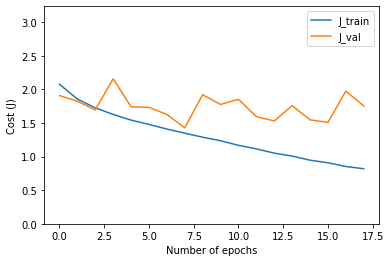

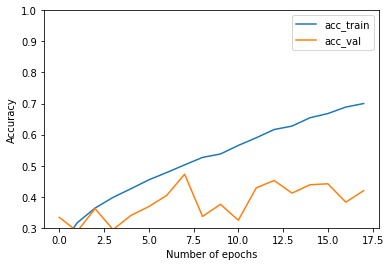

40/40 [==============================] - 0s 6ms/step - loss: 1.4715 - accuracy: 0.4530
Loss & accuracy on test set: 1.471501111984253 0.45303866267204285


In [ ]:
model_checkpoint_folder = './chkpts_annbsc_cnn_multiclasscl'
LOAD_MODEL_FROM_CHECKPOINT = False
checkpoint_name_to_load = 'cp-0040.ckpt'

if LOAD_MODEL_FROM_CHECKPOINT and os.path.isdir(model_checkpoint_folder):
    # load weights from checkpoint saved previously
    
    checkpoint_path = os.path.join(model_checkpoint_folder, checkpoint_name_to_load)
    cl_model.load_weights(checkpoint_path)
    print("Model loaded from checkpoint:", checkpoint_path)
    
else:
    # initialize weights from scratch, train weights
    print("Checkpoint folder was not found. Training classifier...")

    model_chkpt = ModelCheckpoint(os.path.join(model_checkpoint_folder, 'cp-{epoch:04d}.ckpt'), verbose=1,\
                                  save_weights_only=True, save_freq=600)
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\
                                         patience=10, restore_best_weights=True)

    history = cl_model.fit(x_train_aug, y_train_aug, batch_size=64, validation_data=(x_val_aug, y_val_aug),
                    epochs=200, verbose=1,
                    callbacks=[earlystopping_callback, model_chkpt])


    tr_losses = history.history['loss']
    val_losses = history.history['val_loss']

    tr_accs = history.history['accuracy']
    val_accs = history.history['val_accuracy']

    plt.clf()
    plt.plot(tr_losses, label="J_train")
    plt.plot(val_losses, label="J_val")
    y_lim_top = np.maximum(np.amax(val_losses[2:]), np.amax(tr_losses[2:]))*1.5
    plt.ylim((0, y_lim_top))
    plt.xlabel("Number of epochs")
    plt.ylabel("Cost (J)")
    plt.legend()
    plt.show();

    plt.clf()
    plt.plot(tr_accs, label="acc_train")
    plt.plot(val_accs, label="acc_val")
    plt.ylim((0.3, 1.))
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show();
    
# test model

test_ce, test_acc = cl_model.evaluate(x_test, y_test, verbose=1)
print("Loss & accuracy on test set:", test_ce, test_acc)

## Predikciók megjelenítése

Betanítás után, ha készült legalább egy checkpoint, annak fájlnevét ('fajlnev.ckpt' formában) a `checkpoint_name_to_load` változónak megadva, a következő futtatáskor már ezek a súlyok töltődnek be, a betanítás kimarad és az alsó két sorban található teszthalmazon való kiértékelés fut le. A checkpoint több fájlból állhat, pl. 'fajlnev.ckpt.index', stb. Ettől függetlenül 'fajlnev.ckpt' néven hivatkozhatunk rá.

**Rajzoljunk ki néhány véletlen képet a teszthalmazból és írjuk ki a háló becsléseit a képekre nézve!**

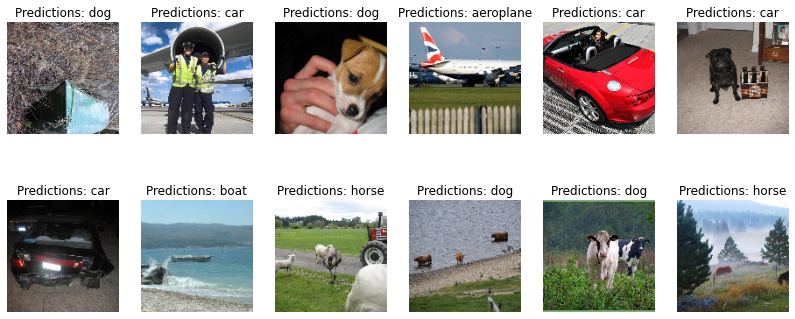

In [ ]:
y_pred_test = cl_model.predict(x_test, verbose=0)
sample_idxs = np.random.choice(x_test.shape[0], size=12)

fig, axs = plt.subplots(2,6)
fig.set_figwidth(14)
fig.set_figheight(6)

for plot_idx in range(12):
    axs[plot_idx//6, plot_idx%6].imshow(x_test[sample_idxs[plot_idx]]*0.5+0.5)
    axs[plot_idx//6, plot_idx%6].axis("off")
    cat_idx = np.argmax(y_pred_test[sample_idxs[plot_idx]])
    axs[plot_idx//6, plot_idx%6].set_title("Predictions: " + CAT_NAMES[cat_idx])

# Transfer learning

![Transfer Learning](https://people.inf.elte.hu/kacago/imgs/transfer_learning.png)

A multi-class klasszifikáció helyett tanítsuk be a neurális hálót kutyák és macskák közötti bináris klasszifikációra. Használjuk fel az előző modelt a flatten réteig és ezen rétegek súlyát fagyasszuk be.


Ezúttal csak a kutyás és macskás képeket szeretnénk bináris klasszifikációhoz felhasználni, a többi képre nincs szükségünk. 

A multi-class klasszifikációra használt adatok közül, melyekre már biztosítottuk, hogy minden képen pontosan 1 kategória szerepel, **válasszuk ki a kutyás és macskás képeket**! Készítsük el az `ys_binary` (n_images,) alakú tömböt, ami minden kutyás/macskás képre 1-es értéket tárol kutya esetén és 0-ás értéket tárol macska esetén!

In [ ]:
CAT_IDX_DOG = 7
CAT_IDX_CAT = 5

dog_mask = ys[:, CAT_IDX_DOG] == 1
cat_mask = ys[:, CAT_IDX_CAT] == 1
cat_or_dog_idxs = np.argwhere(dog_mask | cat_mask).reshape(-1)

xs_binary = xs[cat_or_dog_idxs]

ys_binary = np.zeros((xs_binary.shape[0],), dtype=np.uint8)
dog_mask = ys[cat_or_dog_idxs, CAT_IDX_DOG] == 1
ys_binary[dog_mask] = 1

xs_binary.shape, ys_binary.shape, np.count_nonzero(ys_binary)

((2247, 128, 128, 3), (2247,), 1204)

## Adatok felosztása

Ismét válasszuk szét a tömböket tanító, validációs és teszthalmazra (60/20/20%)!

In [ ]:
val_offset = int(xs_binary.shape[0]*0.6)
test_offset = int(xs_binary.shape[0]*0.8)

x_train_unnormed_binary = xs_binary[:val_offset]
x_val_unnormed_binary = xs_binary[val_offset:test_offset]
x_test_unnormed_binary = xs_binary[test_offset:]
y_train_unnormed_binary = ys_binary[:val_offset]
y_val_unnormed_binary = ys_binary[val_offset:test_offset]
y_test_unnormed_binary = ys_binary[test_offset:]

## Adatok normalizálása

Hasonlóan az előző feladathoz normalizáljuk adatainkat

In [ ]:
mean_intensity, std_of_intensity = 127.5, 1.

x_train_binary = x_train_unnormed_binary.astype(np.float32)/mean_intensity - std_of_intensity
x_val_binary = x_val_unnormed_binary.astype(np.float32)/mean_intensity - std_of_intensity
x_test_binary = x_test_unnormed_binary.astype(np.float32)/mean_intensity - std_of_intensity
y_train_binary = y_train_unnormed_binary.astype(np.float32)
y_val_binary = y_val_unnormed_binary.astype(np.float32)
y_test_binary = y_test_unnormed_binary.astype(np.float32)

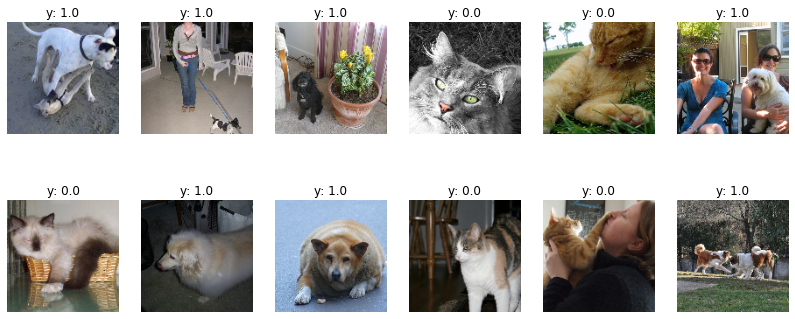

In [ ]:
sample_idxs = np.random.choice(x_train_binary.shape[0], size=12)

fig, axs = plt.subplots(2, 6)
fig.set_figheight(6)
fig.set_figwidth(14)
for plot_idx in range(12):
    axs[plot_idx//6, plot_idx%6].imshow(x_train_binary[sample_idxs[plot_idx]]*0.5 + 0.5)
    axs[plot_idx//6, plot_idx%6].axis('off')
    axs[plot_idx//6, plot_idx%6].set_title("y: " + str(y_train_binary[sample_idxs[plot_idx]]))

## Adataugmentáció

Augmentációkor egyszerűbb dolgunk van, ha a **a Keras ImageDataGenerator osztályát használjuk**.

Az ImageDataGenerator egy generátort fog elkészíteni. A generátor egyfajta iterátor, működésének részleteit lásd a _"Python tutorial - Iterátorok és generátorok"_ című notebookban. Az ImageDataGenerator lényege, hogy a megadott adatbázisból véletlenszerűen választ képeket és a kívánt augmentációkkal, különböző módon, véletlenszerűen augmentál minden egyes képet. Az ImageDataGenerator által konstruált iterátor ilyen, véletlenszerűen választott és augmentált képek és a hozzájuk tartozó címkék batch-eit (kötegeit) adja vissza, ami aztán inputként-outputként használható a betanításhoz. 

A már ismert Keras Model `fit(...)` tagfüggvény azonban fix méretű input és címke tömböket vár paraméterként, ezeken iterál végig újra és újra. Ahhoz, hogy generátorral tudjunk betanítani, a Model `fit_generator(...)` tagfüggvényét kell használnunk.

**Megjegyzés:** A legújabb tensorflow.keras verzióban a `fit_generator(...)` függvény helyett már a `fit(...)` függvény is elfogad generátort paraméterként.

**Készítsük el a betanításhoz az ImageDataGenerator példányunkat!** Paraméterként adjuk meg a használni kívánt augmentációs módszereket és azok mértékét! Mivel nem számjegyeket klasszifikálunk, nyugodtan használhatunk tükrözéseket, forgatásokat is az eltolások, skálázások mellett. Tanításhoz és validáláshoz használhatjuk ugyanazokat az augmentációs módszereket.

Az input-output batch-eket előállító iterátorokat a következő kódblokkban készítjük el, az ImageDataGenerator példány `flow()` tagfüggvéynének meghívásával. Ezt fogjuk a `fit_generator(...)` függvénynek paraméterként megadni a betanításhoz. A `flow()`-t kétszer hívjuk meg, külön iterátorokat állítunk elő a tanítóhalmazhoz és a validációs halmazhoz is.*

In [ ]:
datagen_params = {
    'rotation_range' : 20,
    'horizontal_flip': True,
    'vertical_flip': True,
    'channel_shift_range': 20
}

datagen = ImageDataGenerator(**datagen_params)

## A háló definiálása

In [ ]:
cl_model.trainable = False
binary_cl_model = Dense(256, activation="relu")(cl_model.layers[-5].output)
binary_cl_model = Dropout(0.5)(binary_cl_model)
binary_cl_model = Dense(64, activation="relu")(binary_cl_model)
binary_cl_model = Dropout(0.5)(binary_cl_model)
binary_cl_model = Dense(1, activation="sigmoid")(binary_cl_model)
binary_cl_model = Model(inputs=cl_model.input, outputs=binary_cl_model)

binary_cl_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
binary_cl_model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28_input (InputLayer) [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 20)      560       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 40)        7240      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 40)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32, 32, 40)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 40)        1444

## A háló betanítása

Checkpoint folder was not found. Training classifier...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
22/22 [==============================] - 7s 286ms/step - loss: 0.7188 - accuracy: 0.4909 - val_loss: 0.6905 - val_accuracy: 0.5457
Epoch 2/200
22/22 [==============================] - 6s 268ms/step - loss: 0.7006 - accuracy: 0.5335 - val_loss: 0.6942 - val_accuracy: 0.4655
Epoch 3/200
22/22 [==============================] - 6s 270ms/step - loss: 0.7015 - accuracy: 0.5067 - val_loss: 0.6902 - val_accuracy: 0.5212
Epoch 4/200
22/22 [==============================] - 6s 275ms/step - loss: 0.6994 - accuracy: 0.5178 - val_loss: 0.6926 - val_accuracy: 0.5323
Epoch 5/200
22/22 [==============================] - 6s 274ms/step - loss: 0.6940 - accuracy: 0.5170 - val_loss: 0.6913 - val_accuracy: 0.5278
Epoch 6/200
22/22 [==============================] - 6s 278ms/step - loss: 0.7071 - accuracy: 0.4876 - val_loss: 0.6919 - val_accuracy: 0.5412
Epoch 7/200
22/22 [==============================] - 6s 272ms/step - loss: 0.6996 - accuracy: 0.4988 - val_loss: 0.6917 - val_accuracy: 0.5323

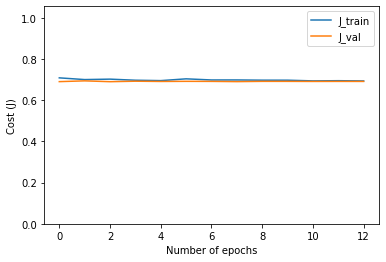

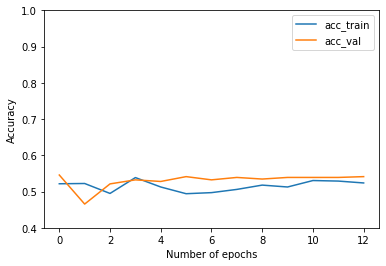

Loss & accuracy on test set: 0.6926428079605103 0.5133333206176758


In [ ]:
model_checkpoint_folder = './chkpts_annbsc_cnn_bincl'
LOAD_MODEL_FROM_CHECKPOINT = False
checkpoint_name_to_load = 'cp-0040.ckpt'

if LOAD_MODEL_FROM_CHECKPOINT and os.path.isdir(model_checkpoint_folder):
    # load weights from checkpoint saved previously
    
    checkpoint_path = os.path.join(model_checkpoint_folder, checkpoint_name_to_load)
    cl_model.load_weights(checkpoint_path)
    print("Model loaded from checkpoint:", checkpoint_path)
    
else:
    # initialize weights from scratch, train weights
    print("Checkpoint folder was not found. Training classifier...")

    model_chkpt = ModelCheckpoint(os.path.join(model_checkpoint_folder, 'cp-{epoch:04d}.ckpt'), verbose=1,\
                                  save_weights_only=True, save_freq=400)
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\
                                         patience=10, restore_best_weights=True)

    train_generator = datagen.flow(x_train_binary, y_train_binary, batch_size=64)
    val_generator = datagen.flow(x_val_binary, y_val_binary, batch_size=64)

    # in case of Model.fit(), one epoch meant an iteration over the whole dataset
    # in case of Model.fit_generator(), one epoch is specified by 
    #         'batch_size' * 'steps_per_epoch' training steps and
    #         'batch_size' * 'validation_steps' validation steps
    history = binary_cl_model.fit_generator(generator=train_generator, validation_data=val_generator,
                                            epochs=200, verbose=1,
                                            callbacks=[earlystopping_callback, model_chkpt])


    tr_losses = history.history['loss']
    val_losses = history.history['val_loss']

    tr_accs = history.history['accuracy']
    val_accs = history.history['val_accuracy']

    plt.clf()
    plt.plot(tr_losses, label="J_train")
    plt.plot(val_losses, label="J_val")
    y_lim_top = np.maximum(np.amax(val_losses[2:]), np.amax(tr_losses[2:]))*1.5
    plt.ylim((0, y_lim_top))
    plt.xlabel("Number of epochs")
    plt.ylabel("Cost (J)")
    plt.legend()
    plt.show();

    plt.clf()
    plt.plot(tr_accs, label="acc_train")
    plt.plot(val_accs, label="acc_val")
    plt.ylim((0.4, 1.))
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show();
    
# test model

test_ce, test_acc = binary_cl_model.evaluate(x_test_binary, y_test_binary, verbose=0)
print("Loss & accuracy on test set:", test_ce, test_acc)

## Predikciók megjelenítése

Rajzoljunk ki néhány véletlen képet a teszthalmazból és írjuk ki a háló becsléseit a képekre nézve!

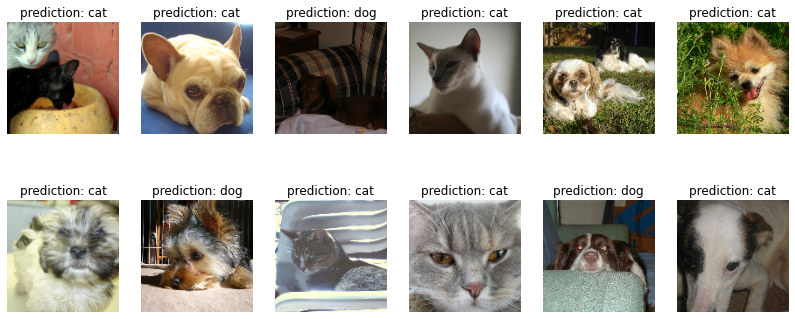

In [ ]:
y_pred_test = binary_cl_model.predict(x_test_binary, verbose=0)
sample_idxs = np.random.choice(x_test_binary.shape[0], size=12)

fig, axs = plt.subplots(2, 6)
fig.set_figheight(6)
fig.set_figwidth(14)
for plot_idx in range(12):
    axs[plot_idx//6, plot_idx%6].imshow(x_test_binary[sample_idxs[plot_idx]]*0.5 + 0.5)
    axs[plot_idx//6, plot_idx%6].axis('off')
    pred_cat_name = 'cat' if y_pred_test[sample_idxs[plot_idx]] < 0.5 else 'dog'
    axs[plot_idx//6, plot_idx%6].set_title("prediction: " + pred_cat_name)

# Szegmentáció

A szegmentációhoz a képek az `arr_seg_data` tömbben vannak, az annotációk pedig az `arr_seg_labs` tömbben. Nézzük meg utóbbinak a típusát és értékeit!

In [ ]:
print(("Shape of the images: ", arr_seg_data.shape))
print("Data type of array containing segmentations: ", arr_seg_labs.dtype)
print("Shape of array containing segmentations: ", arr_seg_labs.shape)

('Shape of the images: ', (1735, 128, 128, 3))
Data type of array containing segmentations:  uint8
Shape of array containing segmentations:  (1735, 128, 128)


Írjuk ki az első képhez tartozó szegmentációs adatok értékeit!

In [ ]:
np.unique(arr_seg_labs[0], return_counts=True)

(array([  0,   1, 255], dtype=uint8), array([14507,   983,   894]))

Írassunk ki pár véletlenszerűen válaszott képet a hozzá tartozó szegmentációval!

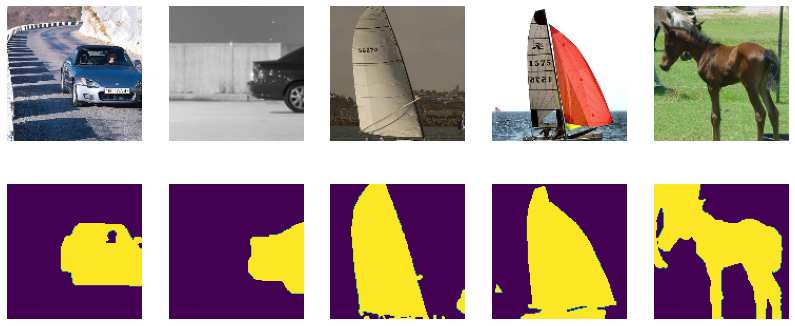

In [ ]:
selected = np.random.choice(len(arr_seg_labs), 5)

plt.figure(figsize=(14, 6))
for i, ind in enumerate(selected):
  plt.subplot(2, 5, i+1)
  plt.imshow(arr_seg_data[ind])
  plt.axis('off')
  plt.subplot(2, 5, i+6)
  seg_img = arr_seg_labs[ind].copy()
  plt.imshow(np.where(seg_img>0, 255, 0))
  plt.axis('off')

# PyTorch

A PyTorch szintén egy neurális hálók használatához készített csomag. API-ja valamivel alacsonyabb szintű, mint a Kerasé.

Példaképpen a 7. előadásban bemutattom MNIST adatbázissal fogunk dolgozni, mely kézzel írt számjegyeket tartalmaz. Az adatokat a `torchvision.datasets` modulból tölthetjük be.




In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Adatbetöltés

Ezután a `DataLoader` függvénnyel kötegekbe rendezhetjük az adatainkat. A `Dataloader` egy iterátort csinál az adatainkból.

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=256)
test_dataloader = DataLoader(test_data, batch_size=256)

## Model definiálása

PyTorhcban háló definiálásához a `torch.nn.Module` osztályból kell származtatnunk. A konstruktorban definiálhatjuk a háló rétegeit, a `forward` függvényben pedig definálhatjuk a közöttük lévő kapcsolatokat.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        preds = self.linear_relu_stack(x)
        return preds

model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

## Tanítás és tesztelés

PyTorchban nekünk kell definiálni, hogy tanítás és tesztelés során mi történjen.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Model betanítása

Megadjuk az epochok számát, majd ennyiszer iterálunk és minden lépésben tanítjuk a modelt, majd kiértékeljük a teszt adatokon.

In [ ]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303821  [    0/60000]
loss: 2.301652  [25600/60000]
loss: 2.299321  [51200/60000]
Test Error: 
 Accuracy: 21.9%, Avg loss: 0.009195 

Epoch 2
-------------------------------
loss: 2.299643  [    0/60000]
loss: 2.297453  [25600/60000]
loss: 2.294362  [51200/60000]
Test Error: 
 Accuracy: 30.1%, Avg loss: 0.009176 

Epoch 3
-------------------------------
loss: 2.294429  [    0/60000]
loss: 2.292104  [25600/60000]
loss: 2.287167  [51200/60000]
Test Error: 
 Accuracy: 28.9%, Avg loss: 0.009147 

Epoch 4
-------------------------------
loss: 2.286575  [    0/60000]
loss: 2.283551  [25600/60000]
loss: 2.273514  [51200/60000]
Test Error: 
 Accuracy: 24.9%, Avg loss: 0.009094 

Epoch 5
-------------------------------
loss: 2.271314  [    0/60000]
loss: 2.266622  [25600/60000]
loss: 2.247967  [51200/60000]
Test Error: 
 Accuracy: 23.8%, Avg loss: 0.009003 

Epoch 6
-------------------------------
loss: 2.243137  [    0/60000]
loss: 2.244894  [256